# 2D prediction for one hole Kevitsa

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt

In [ ]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)


C:\Users\23478671\AppData\Local\Temp\ipykernel_21656\2476643891.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[columns_to_normalize] = scaler.fit_transform(hole_data[columns_to_normalize])


- Iteration 0, MSE : 1.51
- Iteration 100, MSE : 0.01
- Iteration 200, MSE : 0.01
- Iteration 300, MSE : 0.01
- Iteration 400, MSE : 0.01
- Iteration 500, MSE : 0.01
- Iteration 600, MSE : 0.01
- Iteration 700, MSE : 0.01
- Iteration 800, MSE : 0.01
- Iteration 900, MSE : 0.01
- Iteration 1000, MSE : 0.01
- Iteration 1100, MSE : 0.01
- Iteration 1200, MSE : 0.01
- Iteration 1300, MSE : 0.01
- Iteration 1400, MSE : 0.01
- Iteration 1500, MSE : 0.01
- Iteration 1600, MSE : 0.01
- Iteration 1700, MSE : 0.01
- Iteration 1800, MSE : 0.01
- Iteration 1900, MSE : 0.01
- Iteration 2000, MSE : 0.01
- Iteration 2100, MSE : 0.01
- Iteration 2200, MSE : 0.01
- Iteration 2300, MSE : 0.01
- Iteration 2400, MSE : 0.01
- Iteration 2500, MSE : 0.01
- Iteration 2600, MSE : 0.01
- Iteration 2700, MSE : 0.01
- Iteration 2800, MSE : 0.01
- Iteration 2900, MSE : 0.01
- Iteration 3000, MSE : 0.01
- Iteration 3100, MSE : 0.01
- Iteration 3200, MSE : 0.01
- Iteration 3300, MSE : 0.01
- Iteration 3400, MSE : 0.

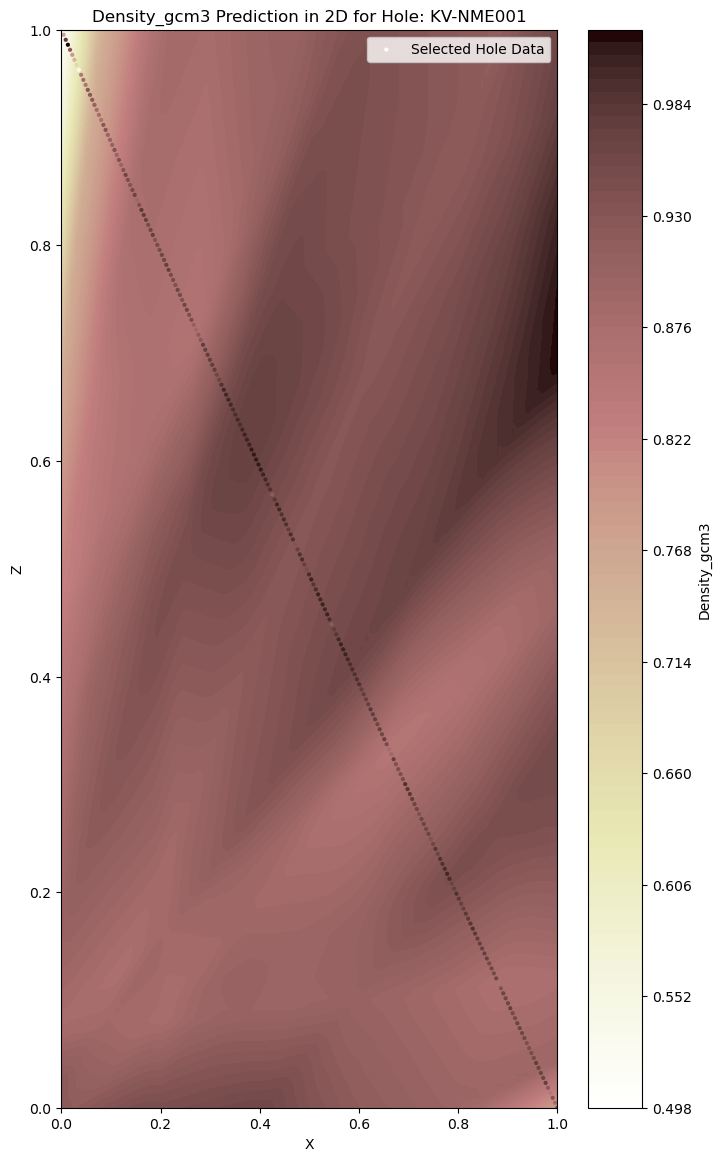

In [42]:
#Subset data for each mineral
mineral = 'Density_gcm3'
two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])





# Define the specific hole you want to predict for
hole_name = 'KV-NME001'


# Filter the data for the selected hole
hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]


# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Define the columns to normalize
columns_to_normalize = ['X','Y', 'Z', mineral]  # Add all columns you want to normalize

# Fit the scaler to your data and transform the specified columns
hole_data[columns_to_normalize] = scaler.fit_transform(hole_data[columns_to_normalize])


# Extract the features (X and Y coordinates) and target (mineral) for the selected hole
x_hole = hole_data[['X', 'Z']].values
y_hole = hole_data[mineral].values[:, np.newaxis]

x_hole = torch.tensor(x_hole)
y_hole = torch.tensor(y_hole)
x_hole = x_hole.to(torch.float32)
y_hole = y_hole.to(torch.float32)

# Create a model for this specific hole
model_hole = nn.Sequential(
    nn.Linear(in_features=2, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model_hole.parameters(), lr=0.01)

for step in range(5000):
    pre = model_hole(x_hole)
    mse = mse_loss(pre, y_hole)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if step % 100 == 0:
        print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))

# Define a grid of points for prediction
x_grid_hole = np.linspace(x_hole[:, 0].min(), x_hole[:, 0].max(), 100)
y_grid_hole = np.linspace(x_hole[:, 1].min(), x_hole[:, 1].max(), 100)
xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

# Make predictions for the grid
predictions_hole = model_hole(torch.tensor(xy_grid_hole, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)

# Plot the contour plot of the mineral predictions for the selected hole
plt.figure(figsize=(8, 14))
contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', levels=100)  # Adjust levels as needed

# Optionally, you can scatter plot the data points for this specific hole
plt.scatter(x_hole.data.numpy()[:, 0], x_hole.data.numpy()[:, 1], c=y_hole.data.numpy(), cmap='pink_r', s=4, label='Selected Hole Data')

plt.colorbar(contour_hole, label=mineral)
plt.legend()
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name}')
plt.show()


In [ ]:
for hole_name in two_composite_filtered['Name'].unique():
    #Subset data for each mineral
    mineral = 'Density_gcm3'
    two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
    two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])

    # Define the specific hole you want to predict for
    hole_name = 'KV-NME001'

    # Filter the data for the selected hole
    hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]

    # Extract the features (X and Y coordinates) and target (mineral) for the selected hole
    x_hole = hole_data[['X', 'Z']].values
    y_hole = hole_data[mineral].values[:, np.newaxis]

    x_hole = torch.tensor(x_hole)
    y_hole = torch.tensor(y_hole)
    x_hole = x_hole.to(torch.float32)
    y_hole = y_hole.to(torch.float32)

    # Create a model for this specific hole
    model_hole = nn.Sequential(
        nn.Linear(in_features=2, out_features=20),
        nn.ReLU(),
        nn.Linear(in_features=20, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model_hole.parameters(), lr=0.01)

    for step in range(6001):
        pre = model_hole(x_hole)
        mse = mse_loss(pre, y_hole)
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if step % 100 == 0:
            print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))

    # Define a grid of points for prediction
    x_grid_hole = np.linspace(x_hole[:, 0].min(), x_hole[:, 0].max(), 100)
    y_grid_hole = np.linspace(x_hole[:, 1].min(), x_hole[:, 1].max(), 100)
    xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
    xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

    # Make predictions for the grid
    predictions_hole = model_hole(torch.tensor(xy_grid_hole, dtype=torch.float32))

    # Reshape the predictions to match the grid shape
    predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)

    # Plot the contour plot of the mineral predictions for the selected hole
    plt.figure(figsize=(14, 8))
    contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='viridis', levels=100)  # Adjust levels as needed

    # Optionally, you can scatter plot the data points for this specific hole
    plt.scatter(x_hole.data.numpy()[:, 0], x_hole.data.numpy()[:, 1], c=y_hole.data.numpy(), cmap='viridis', s=4, label='Selected Hole Data')

    plt.colorbar(contour_hole, label=mineral)
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name}')
    plt.show()
